## Econometric Analysis
* Loading Oil Price Data

* Downloading idicators dataset

* Understanding the Data

* Data Visualization

Import neccessary libraries and modules

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

# Set max rows and columns to display
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Configure logging
from logging_setup import SetupLogger


logger = SetupLogger(log_file='../logs/notebooks.log').get_logger()

# Set default figure size for all plots
plt.rcParams['figure.figsize'] = (14, 7)

In [3]:
# Read the data
# Load data into a pandas DataFrame
price_data = pd.read_csv('../data/data.csv')
price_data['Date'] = pd.to_datetime(price_data['Date'], format='mixed')
price_data.set_index('Date', inplace=True)

## Download Economic Indicators Dataset from World bank

In [4]:
import wbdata

def fetch_data(indicator_code, indicator_name, country='WLD', start_date=None, end_date=None):
    """Fetches data from World Bank Data for a specified indicator."""
    data = wbdata.get_dataframe({indicator_code: indicator_name}, country=country, date=(start_date, end_date))
    return data

def clean_data(df):
    """Cleans the DataFrame by resetting index, renaming columns, and handling missing values."""
    if df is not None and not df.empty:
        df.reset_index(inplace=True)
        df.columns = ['date', df.columns[1]]  # Keep the first column as 'date', second as the indicator name
        df.dropna(inplace=True)
        df['date'] = pd.to_datetime(df['date'])
        return df
    return pd.DataFrame()  # Return an empty DataFrame if input is None or empty

def convert_to_daily(df):
    """Converts a DataFrame with dates to a daily frequency."""
    full_index = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
    df_daily = df.set_index('date').reindex(full_index)
    df_daily.interpolate(method='time', inplace=True)  # Interpolate to fill missing values
    df_daily.reset_index(inplace=True)
    df_daily.rename(columns={'index': 'Date'}, inplace=True)
    return df_daily

# Set the indicator codes
gdp_indicator = 'NY.GDP.MKTP.CD'                # GDP (current US$)
cpi_indicator = 'FP.CPI.TOTL.ZG'                    # Inflation (CPI)
unemployment_indicator = 'SL.UEM.TOTL.ZS'        # Unemployment rate (% of total labor force)
exchange_rate_indicator = 'PA.NUS.FCRF'         # Exchange rate, USD to other currencies

# Define the date range
start_date = '1987-05-20'
end_date = '2022-11-14'

# Fetch and clean data for each indicator
gdp_data = clean_data(fetch_data(gdp_indicator, 'GDP', country='WLD', start_date=start_date, end_date=end_date))
cpi_data = clean_data(fetch_data(cpi_indicator, 'CPI', country='WLD', start_date=start_date, end_date=end_date))
unemployment_data = clean_data(fetch_data(unemployment_indicator, 'Unemployment Rate', country='WLD', start_date=start_date, end_date=end_date))
exchange_rate_data = clean_data(fetch_data(exchange_rate_indicator, 'Exchange Rate', country='EMU', start_date=start_date, end_date=end_date))

# Convert to daily frequency
gdp_data_daily = convert_to_daily(gdp_data)
cpi_data_daily = convert_to_daily(cpi_data)
unemployment_data_daily = convert_to_daily(unemployment_data)
exchange_rate_data_daily = convert_to_daily(exchange_rate_data)

# Save each cleaned DataFrame to a CSV file
gdp_data_daily.to_csv("../data/GDP_cleaned_data_daily.csv", index=False)
cpi_data_daily.to_csv("../data/CPI_cleaned_data_daily.csv", index=False)
unemployment_data_daily.to_csv("../data/Unemployment_Rate_cleaned_data_daily.csv", index=False)
exchange_rate_data_daily.to_csv("../data/Exchange_Rate_cleaned_data_daily.csv", index=False)

[27/Feb/2025 20:53:30] WARNING - /etc/timezone is deprecated on Debian, and no longer reliable. Ignoring.


### Investigate relationships between econometric indicators and oil prices

Correlation between GDP and oil prices: 0.7563009785972024


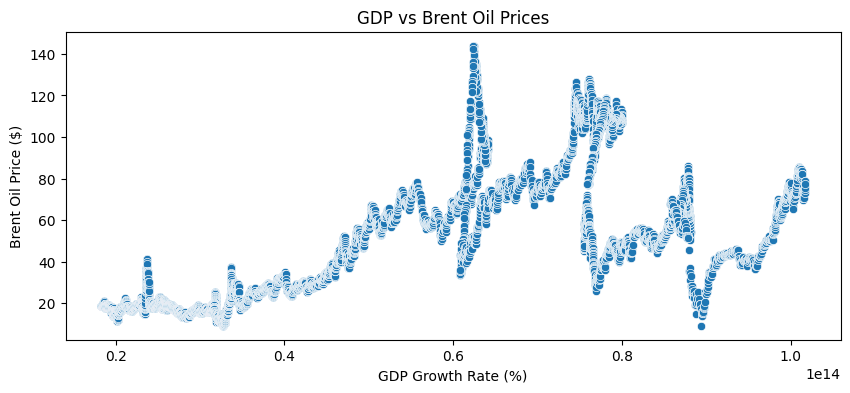

Correlation between CPI and oil prices: -0.40955574129306516


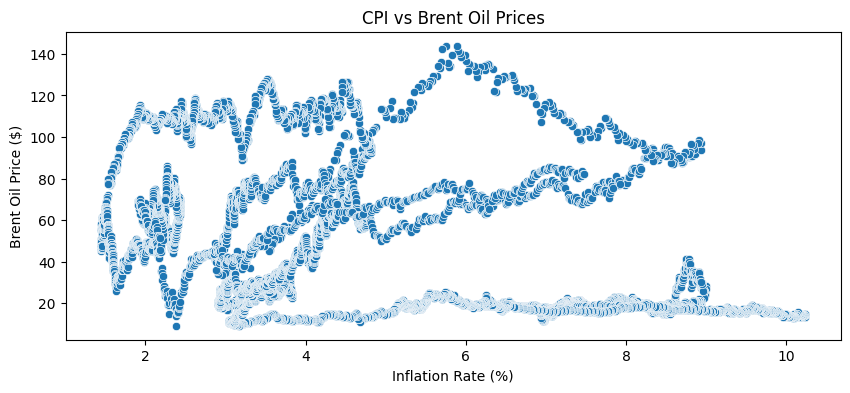

Correlation between Unemployment Rate and oil prices: 0.04469839993763748


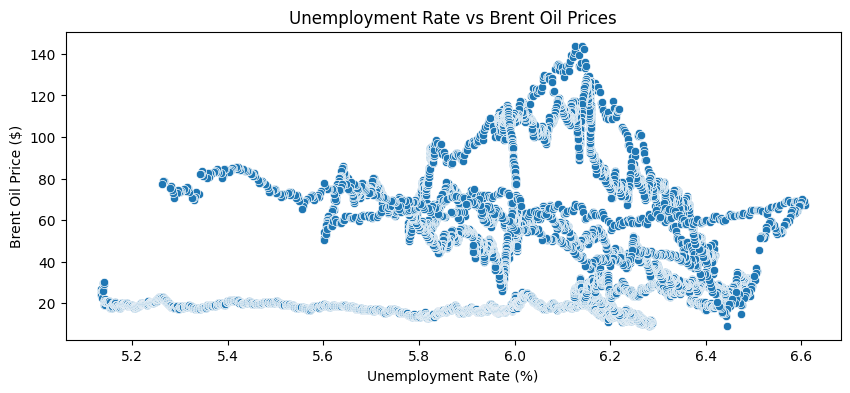

Correlation between Exchange Rate and oil prices: -0.6736337150209106


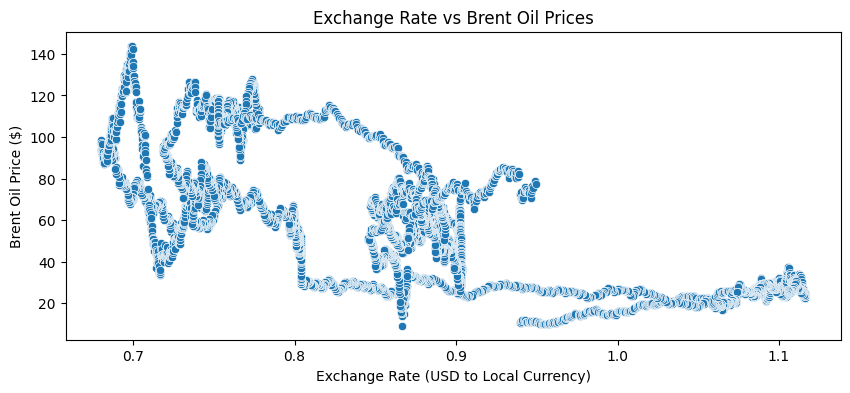

In [5]:
def analyze_indicators(gdp_data, inflation_data, unemployment_data, exchange_rate_data, oil_data):
    """
    Analyzes the correlation between economic indicators and oil prices,
    and generates scatter plots for each indicator.
    
    Parameters:
    gdp_data (DataFrame): Daily GDP data with columns ['Date', 'GDP'].
    inflation_data (DataFrame): Daily inflation data with columns ['Date', 'CPI'].
    unemployment_data (DataFrame): Daily unemployment data with columns ['Date', 'Unemployment Rate'].
    exchange_rate_data (DataFrame): Daily exchange rate data with columns ['Date', 'Exchange Rate'].
    oil_data (DataFrame): Daily oil price data with columns ['Date', 'Price'].
    """
    
    # Function to merge and analyze
    def analyze_and_plot(indicator_data, indicator_name, oil_data, x_label):
        merged_data = pd.merge(indicator_data, oil_data.reset_index(), on='Date')
        
        # Drop NaN values to ensure correlation calculation is valid
        merged_data.dropna(inplace=True)
        correlation = merged_data[indicator_name].corr(merged_data['Price'])
        print(f"Correlation between {indicator_name} and oil prices: {correlation}")

        # Scatter plot
        plt.figure(figsize=(10, 4))
        sns.scatterplot(data=merged_data, x=indicator_name, y='Price')
        plt.title(f'{indicator_name} vs Brent Oil Prices')
        plt.xlabel(x_label)
        plt.ylabel('Brent Oil Price ($)')
        plt.show()

    # Analyze GDP
    analyze_and_plot(gdp_data, 'GDP', oil_data, 'GDP Growth Rate (%)')

    # Analyze Inflation
    analyze_and_plot(inflation_data, 'CPI', oil_data, 'Inflation Rate (%)')

    # Analyze Unemployment
    analyze_and_plot(unemployment_data, 'Unemployment Rate', oil_data, 'Unemployment Rate (%)')

    # Analyze Exchange Rate
    analyze_and_plot(exchange_rate_data, 'Exchange Rate', oil_data, 'Exchange Rate (USD to Local Currency)')

# Example of calling the function
# Ensure you have the cleaned daily data for each indicator ready
# gdp_data_daily, cpi_data_daily, unemployment_data_daily, exchange_rate_data_daily, and price_data_daily
analyze_indicators(gdp_data_daily, cpi_data_daily, unemployment_data_daily, exchange_rate_data_daily, price_data)

In [6]:
# gdp_data_daily, exchange_rate_data_daily they have strong correlation with price
# Merge all datasets on 'Date' column
merged_data = (
    gdp_data_daily
    .merge(exchange_rate_data_daily, on='Date', how='outer')
    .merge(price_data.reset_index(), on='Date', how='outer')
)

# Fill missing values with forward fill for consistency if there are any gaps
merged_data.ffill(inplace=True)

# Save to csv file
merged_data.to_csv('../data/features.csv', index=False)